# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!pip -q install 'tensorflow-privacy==0.5.2'
#!pip -q install git+https://github.com/tensorflow/privacy #TODO fix this

     |████████████████████████████████| 194kB 7.3MB/s 


##### Import libraries

In [4]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

#import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [5]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:11, 69.5MB/s]


##### Define constants

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 16
IMG_SHAPE = [256, 256, 3] # original dataset image size is 299x299x3
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.88
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [7]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [8]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [9]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [10]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [11]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=TEST_SPLIT, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VAL_SPLIT, random_state=random_state)

In [12]:
TRAIN_IMG_COUNT = len(y_train)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7299, Val: 385, Test: 1356


In [13]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [14]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4380, 'COVID-19': 2919}
val set:  {'normal': 227, 'COVID-19': 158}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [15]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [16]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [17]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [18]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [19]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [20]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [21]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [22]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [23]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [24]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1,
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1,
                                augment=False)

y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [25]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

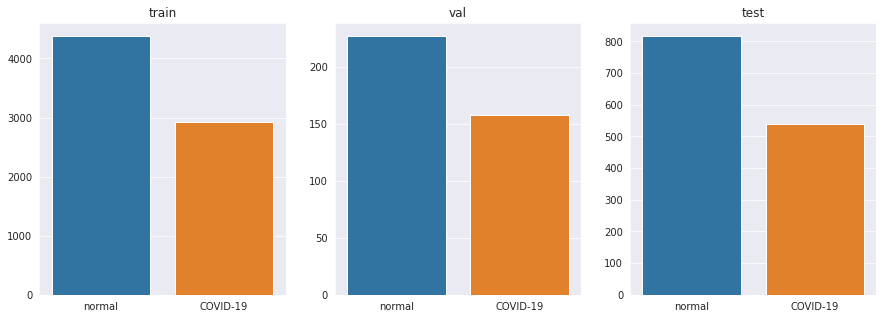

In [26]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [27]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [28]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


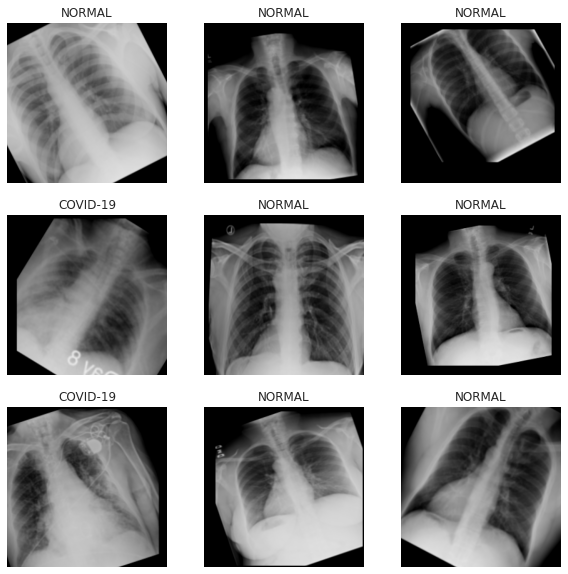

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [30]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [31]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## Cifar10 - CNN Architecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [46]:
def cifar10_builder():
    # create DP-Net
    cifar10 = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2,2), strides=2),
        #Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        #BatchNormalization(),
        #Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        #BatchNormalization(),
        #AveragePooling2D(pool_size=(2,2), strides=2),
        ##Flatten(),
        ##Dense(units=128, activation='tanh'),
        ##BatchNormalization(),
        ##Dense(units=1, activation='sigmoid'),
        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        BatchNormalization(),
        Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(units=1, activation='sigmoid'),
    ], name='Cifar10')
    return cifar10

In [47]:
cifar10 = cifar10_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

cifar10.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [48]:
cifar10.summary()

Model: "Cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_22 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 252, 252, 32)      128       
_________________________________________________________________
average_pooling2d_8 (Average (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 124, 124, 64)      256 

### Training

In [49]:
history_cifar10 = cifar10.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


456/456 [==============================] - 556s 1s/step - loss: 0.6891 - accuracy: 0.6400 - precision: 0.5552 - recall: 0.5636 - val_loss: 0.6708 - val_accuracy: 0.6068 - val_precision: 0.5327 - val_recall: 0.3608
Epoch 2/20
456/456 [==============================] - 507s 1s/step - loss: 0.6832 - accuracy: 0.6172 - precision: 0.6597 - recall: 0.0995 - val_loss: 0.7659 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
456/456 [==============================] - 507s 1s/step - loss: 0.6906 - accuracy: 0.6131 - precision: 0.7277 - recall: 0.0347 - val_loss: 0.6655 - val_accuracy: 0.6771 - val_precision: 0.5759 - val_recall: 0.8165
Epoch 4/20
456/456 [==============================] - 507s 1s/step - loss: 0.7191 - accuracy: 0.6036 - precision: 0.6376 - recall: 0.0101 - val_loss: 0.8945 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
456/456 [==============================] - 507s 1s/step - loss: 0.7554 - accuracy: 0

### Evaluation

###### Visualize performance

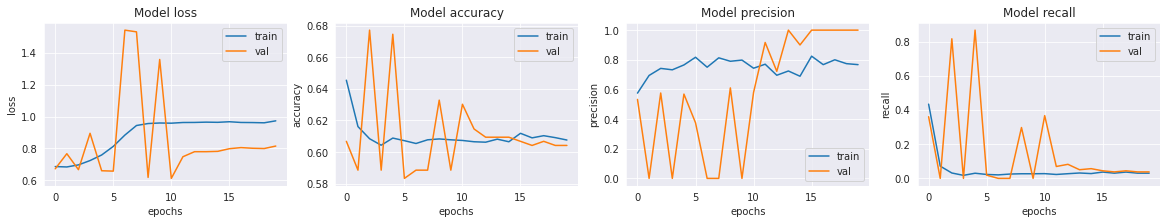

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_cifar10.history[met])
    ax[i].plot(history_cifar10.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [51]:
loss, acc, prec, rec = cifar10.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 2s 23ms/step - loss: 0.8036 - accuracy: 0.6158 - precision: 0.8750 - recall: 0.0390
Loss of the model is -  0.8036459684371948
Accuracy of the model is -  61.57817244529724 %
Precision of the model is -  0.875
Recall of the model is -  0.03896103799343109


## Cifar10 - relu
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [61]:
def cifar10_relu_builder():
    # create DP-Net
    cifar10 = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2,2), strides=2),
        #Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        #BatchNormalization(),
        #Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        #BatchNormalization(),
        #AveragePooling2D(pool_size=(2,2), strides=2),
        ##Flatten(),
        ##Dense(units=128, activation='tanh'),
        ##BatchNormalization(),
        ##Dense(units=1, activation='sigmoid'),
        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        BatchNormalization(),
        Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(units=1, activation='sigmoid'),
    ], name='Cifar10')
    return cifar10

In [62]:
cifar10_relu = cifar10_relu_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

cifar10_relu.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [63]:
cifar10_relu.summary()

Model: "Cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_44 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_45 (Batc (None, 252, 252, 32)      128       
_________________________________________________________________
average_pooling2d_16 (Averag (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 124, 124, 64)      256 

### Training

In [64]:
history_cifar10_relu = cifar10_relu.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


456/456 [==============================] - 517s 1s/step - loss: 0.6529 - accuracy: 0.6308 - precision: 0.5368 - recall: 0.6533 - val_loss: 0.8568 - val_accuracy: 0.4115 - val_precision: 0.4115 - val_recall: 1.0000
Epoch 2/20
456/456 [==============================] - 506s 1s/step - loss: 0.6150 - accuracy: 0.6753 - precision: 0.5894 - recall: 0.6494 - val_loss: 0.6600 - val_accuracy: 0.6302 - val_precision: 0.5290 - val_recall: 0.9241
Epoch 3/20
456/456 [==============================] - 506s 1s/step - loss: 0.6235 - accuracy: 0.6640 - precision: 0.6033 - recall: 0.5247 - val_loss: 2.7532 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
456/456 [==============================] - 506s 1s/step - loss: 0.6492 - accuracy: 0.6683 - precision: 0.6235 - recall: 0.4557 - val_loss: 0.7928 - val_accuracy: 0.5651 - val_precision: 0.2857 - val_recall: 0.0380
Epoch 5/20
456/456 [==============================] - 506s 1s/step - loss: 0.6688 - accuracy: 0.6787 - 

### Evaluation

###### Visualize performance

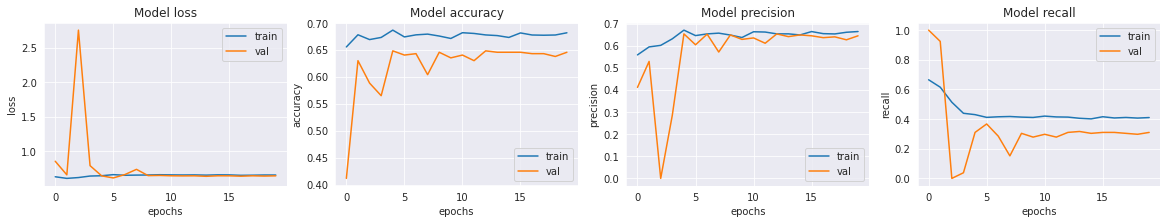

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_cifar10_relu.history[met])
    ax[i].plot(history_cifar10_relu.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [66]:
loss, acc, prec, rec = cifar10_relu.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 2s 17ms/step - loss: 0.6333 - accuracy: 0.6733 - precision: 0.7000 - recall: 0.3117
Loss of the model is -  0.6332834362983704
Accuracy of the model is -  67.33038425445557 %
Precision of the model is -  0.699999988079071
Recall of the model is -  0.31168830394744873


## Cifar10 - nobn
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [67]:
def cifar10_nobn_builder():
    # create DP-Net
    cifar10 = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        AveragePooling2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        AveragePooling2D(pool_size=(2,2), strides=2),
        #Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        #Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        #AveragePooling2D(pool_size=(2,2), strides=2),
        ##Flatten(),
        ##Dense(units=128, activation='tanh'),
        ##BatchNormalization(),
        ##Dense(units=1, activation='sigmoid'),
        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='valid', activation='tanh'),
        GlobalAveragePooling2D(),
        Dense(units=1, activation='sigmoid'),
    ], name='Cifar10')
    return cifar10

In [68]:
cifar10_nobn = cifar10_nobn_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

cifar10_nobn.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [69]:
cifar10_nobn.summary()

Model: "Cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
average_pooling2d_18 (Averag (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
average_pooling2d_19 (Averag (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 59, 59, 128)       7385

### Training

In [70]:
history_cifar10_nobn = cifar10_nobn.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


456/456 [==============================] - 266s 568ms/step - loss: 0.6937 - accuracy: 0.4029 - precision: 0.4028 - recall: 0.9994 - val_loss: 0.6905 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
456/456 [==============================] - 258s 566ms/step - loss: 0.6960 - accuracy: 0.5937 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6862 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
456/456 [==============================] - 258s 566ms/step - loss: 0.6957 - accuracy: 0.5971 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6804 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
456/456 [==============================] - 258s 566ms/step - loss: 0.6982 - accuracy: 0.6004 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6785 - val_accuracy: 0.5885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
456/456 [=======================

### Evaluation

###### Visualize performance

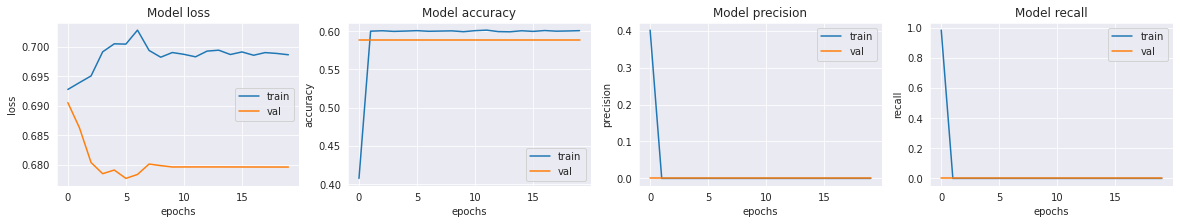

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_cifar10_nobn.history[met])
    ax[i].plot(history_cifar10_nobn.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

###### Predict on test set

In [72]:
loss, acc, prec, rec = cifar10_nobn.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

85/85 [==============================] - 1s 16ms/step - loss: 0.6766 - accuracy: 0.6025 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss of the model is -  0.6766195893287659
Accuracy of the model is -  60.25073528289795 %
Precision of the model is -  0.0
Recall of the model is -  0.0


## Evaluation

In [73]:
models = [
    cifar10,
    cifar10_relu,
    cifar10_nobn,
]

### Model Analysis

In [74]:
for model in models:
    print("Evaluating %s ..." % (model.name))
    loss, acc, prec, rec = model.evaluate(test_batched)
    print('\n')

Evaluating Cifar10 ...
85/85 [==============================] - 2s 19ms/step - loss: 0.8036 - accuracy: 0.6158 - precision: 0.8750 - recall: 0.0390


Evaluating Cifar10 ...
85/85 [==============================] - 1s 14ms/step - loss: 0.6333 - accuracy: 0.6733 - precision: 0.7000 - recall: 0.3117


Evaluating Cifar10 ...
85/85 [==============================] - 1s 16ms/step - loss: 0.6766 - accuracy: 0.6025 - precision: 0.0000e+00 - recall: 0.0000e+00




### Privacy Analysis

#### Compute epsilon

In [75]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [76]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [77]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 1.379


In [78]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 2.0
noise = compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)
print(noise)

DP-SGD with sampling rate = 0.219% and noise_multiplier = 0.7671386547553539 iterated over 9124 steps satisfies differential privacy with eps = 2 and delta = 0.0001.
0.7671386547553539


#### Membership Inference Attack

In [79]:
# run membership inference attack
def run_mia(model, x_train_attack, x_test_attack, y_train_attack, y_test_attack):
    # predict on train
    probs_train = model.predict(x_train_attack)
    # predict on test
    probs_test = model.predict(x_test_attack)

    # only label as output instead of prob
    #probs_train = np.round(logits_train)
    #probs_test = np.round(logits_test)

    # compute losses
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant

    loss_train = np.array([x[0] for x in bc(constant([[y] for y in y_train_attack]), constant(probs_train), from_logits=False).numpy()])
    loss_test = np.array([x[0] for x in bc(constant([[y] for y in y_test_attack]), constant(probs_test), from_logits=False).numpy()])

    # labels
    train_labels = np.array(y_train_attack)
    test_labels = np.array(y_test_attack)

    # prepare attacks
    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = train_labels,
        labels_test = test_labels
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,)

    attack_types = [
        AttackType.THRESHOLD_ATTACK,
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    plt.show()

    # print a user-friendly summary of the attacks
    print(attacks_result.summary(by_slices=False)) #TODO fix low auc sometimes

Membership Inference Attack on Cifar10...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


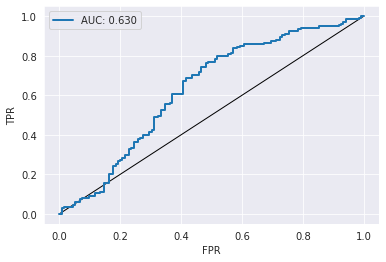

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.63 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.28 on slice CLASS=1


Membership Inference Attack on Cifar10...
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier


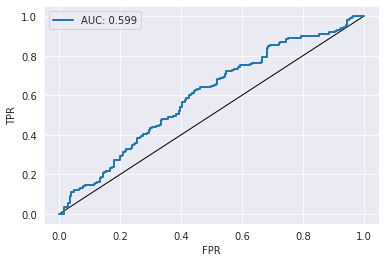

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 2919 training and 539 test examples) achieved an AUC of 0.35 on slice CLASS=1
  THRESHOLD_ATTACK (with 2919 training and 539 test examples) achieved an advantage of 0.27 on slice CLASS=1


Membership Inference Attack on Cifar10...


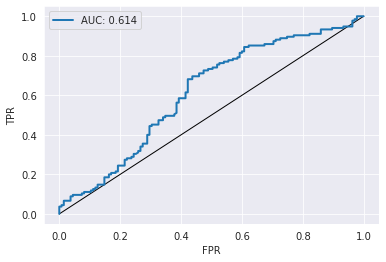

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.61 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.26 on slice CLASS=1




In [80]:
for model in models:
    print('Membership Inference Attack on '+model.name+'...')
    run_mia(model, x_train_attack, x_test_attack, y_train_attack, y_test_attack)
    print('\n')